In [44]:
%matplotlib inline

In [45]:
import sys
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt

sys.path.append('../datasets/')
sys.path.append('../nets/')
sys.path.append('../preprocessing/')

import orientset
oriset = orientset.get_split('', '../data/tfrecord/')

In [46]:
def ori_network(inputs, is_training=True, keep_prob=0.5, scope='ori_network'):
    with tf.variable_scope(scope, 'ori_network', [inputs]) as sc:
        with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        normalizer_fn=slim.batch_norm,
                        normalizer_params={'is_training': is_training, 'decay': 0.95},
                        weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                        weights_regularizer=slim.l2_regularizer(0.0005)):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1', normalizer_fn=None)
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2', normalizer_fn=None)
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3', normalizer_fn=None)
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4', normalizer_fn=None)
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5', normalizer_fn=None)
            net = slim.max_pool2d(net, [2, 2], scope='pool5')
            net = slim.conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
            net = slim.dropout(net, keep_prob, is_training=is_training,
                         scope='dropout6')
            # fully-connected network
            net = slim.fully_connected(net, 4096, scope='fc7',)
            net = slim.dropout(net, keep_prob, is_training=is_training, scope='dropout7')
            # output layer which has four classes
            net = slim.fully_connected(net, 4, scope='fc8', activation_fn=None)
            net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
            return net

In [47]:
import vgg_preprocessing, vgg

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-1343
(array([[ 0.15369742,  0.07292899,  0.67317551,  0.10019814]], dtype=float32), array([2]))


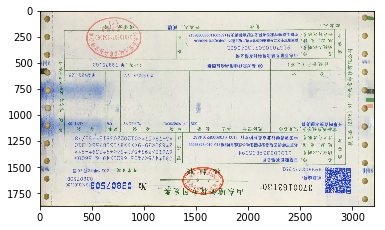

In [48]:
with tf.Graph().as_default():
    # read test data set
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        oriset, common_queue_capacity=32, common_queue_min=1)

    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            VGG_IMAGE_SIZE = vgg.vgg_16.default_image_size
            image_pro = vgg_preprocessing.preprocess_for_eval(image, VGG_IMAGE_SIZE, VGG_IMAGE_SIZE, 256)
            image_ex = tf.expand_dims(image_pro, 0)
            logits = ori_network(image_ex, is_training=False)
            probabilities = tf.nn.softmax(logits)

            init_fn = slim.assign_from_checkpoint_fn('../checkpoints/model.ckpt-1343', slim.get_model_variables())
            
            init_fn(sess)
            np_image, probs, gth = sess.run([image, probabilities, label])
            print(probs, gth)
            plt.figure()
            plt.imshow(np_image)

## for a single image

In [ ]:
import cv2
import numpy as np

In [49]:
base_dir = '../data/output/oppo/'

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-1343
zxcFmTQsnCrxOFH3yShcQ68bx3cJTEhEp46U3QE_AwqAM1ur6UfXbL6sojyrfLC3.jpg
[array([[ 0.11753611,  0.05831493,  0.73126507,  0.09288377]], dtype=float32)]
dIwZ9gd7Inl1lFuWNrPpDTsI4BrPee3fh6AQ--8dBPVTsd0pdV2fSj5p6jbwhgGG.jpg
[array([[ 0.8999337 ,  0.02113293,  0.03389292,  0.04504048]], dtype=float32)]
SzJZPQkypaTR3cA0CGFaFn7VedKPqWAUjZIw-vb0YxlLYGhuGOeZ1s6C-X-cx6fL.jpg
[array([[ 0.09286407,  0.65365386,  0.13297634,  0.12050579]], dtype=float32)]
oxiIRqZ2-MnPXknEweCZy98xsZDy6TxOeA6QPvrA1km8pJDOf_0AaYSBIoirc5nh.jpg
[array([[ 0.83853763,  0.04024218,  0.06581945,  0.05540078]], dtype=float32)]


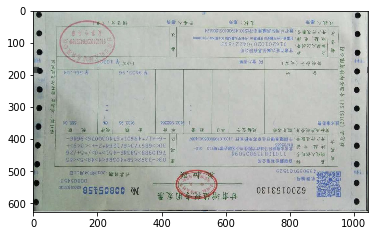

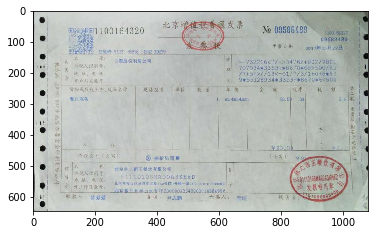

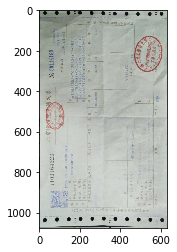

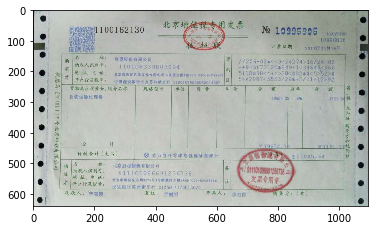

In [51]:
VGG_IMAGE_SIZE = vgg.vgg_16.default_image_size
with tf.Graph().as_default():
    inputs_ = tf.placeholder(tf.float32, [None, VGG_IMAGE_SIZE, VGG_IMAGE_SIZE, 3])
    logits = ori_network(inputs_, is_training=False)
    probabilities = tf.nn.softmax(logits)
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            init_fn = slim.assign_from_checkpoint_fn('../checkpoints/model.ckpt-1343', slim.get_model_variables())
            init_fn(sess)
            # read the image file
            for testfile in os.listdir(base_dir)[:4]:
                path = os.path.join(base_dir, testfile)
                image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
                image_pro = vgg_preprocessing.preprocess_for_eval(image, VGG_IMAGE_SIZE, VGG_IMAGE_SIZE, 256)
                image_ex = tf.expand_dims(image_pro, 0)
                probs = sess.run([probabilities], feed_dict={inputs_:image_ex.eval()})
                print(testfile)
                print(probs)
                plt.figure()
                plt.imshow(image)